In [1]:
! huggingface-cli login  --token ''


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
The token `My_token` has been saved to /home/ubuntu/.cache/huggingface/stored_tokens
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful.
The current active token is: `My_token`


In [2]:
import torch

# Assuming you have access to a Llama model (replace with your actual model)
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Or another suitable Llama model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

The model is fine-tuned only on ~80-100 examples of each class, 15 classes in total.

In [45]:
import os
import pickle

data_dir = '/home/ubuntu/fin_experiment/data/financial_relation_extraction'
with open(os.path.join(data_dir, 'messages_train.pkl'), 'rb') as inp:
    messages = pickle.load(inp)
with open(os.path.join(data_dir, 'messages_valid.pkl'), 'rb') as inp:
    messages_valid = pickle.load(inp)
with open(os.path.join(data_dir, 'messages_test.pkl'), 'rb') as inp:
    messages_test = pickle.load(inp)

In [62]:
from datasets import Dataset

train_dataset = Dataset.from_dict({"messages": messages})
train_dataset = train_dataset.shuffle(seed=42) 

valid_dataset = Dataset.from_dict({"messages": messages_valid})
valid_dataset = valid_dataset.shuffle(seed=42) 

test_dataset = Dataset.from_dict({"messages": messages_test})
test_dataset = test_dataset.shuffle(seed=42)


In [33]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [34]:
# PEFT fine-tuning
from peft import LoraConfig

# TODO: Configure LoRA parameters
# r: rank dimension for LoRA update matrices (smaller = more compression)
rank_dimension = 6
# lora_alpha: scaling factor for LoRA layers (higher = stronger adaptation)
lora_alpha = 8
# lora_dropout: dropout probability for LoRA layers (helps prevent overfitting)
lora_dropout = 0.05

peft_config = LoraConfig(
    r=rank_dimension,  # Rank dimension - typically between 4-32
    lora_alpha=lora_alpha,  # LoRA scaling factor - typically 2x rank
    inference_mode=False,
    lora_dropout=lora_dropout,  # Dropout probability for LoRA layers
    bias="none",  # Bias type for LoRA. the corresponding biases will be updated during training.
    target_modules="all-linear",  # Which modules to apply LoRA to
    task_type="CAUSAL_LM",  # Task type for model architecture
)

In [36]:
from peft import get_peft_model


model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name
).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
model.enable_input_require_grads()
model = get_peft_model(model, peft_config)
model.config.pad_token_id = model.config.eos_token_id


In [37]:
model.print_trainable_parameters()


trainable params: 4,227,072 || all params: 1,240,041,472 || trainable%: 0.3409


In [38]:
from trl import SFTConfig, SFTTrainer, setup_chat_format

# Training configuration
# Hyperparameters based on QLoRA paper recommendations
args = SFTConfig(
    # Output settings
    output_dir='relations_llama',  # Directory to save model checkpoints
    # Training duration
    num_train_epochs=3,  # Number of training epochs
    # Batch size settings
    per_device_train_batch_size=1,  # Batch size per GPU
    gradient_accumulation_steps=8,  # Accumulate gradients for larger effective batch
    # Memory optimization
    gradient_checkpointing=True,  # Trade compute for memory savings
    # Optimizer settings
    optim="adamw_torch_fused",  # Use fused AdamW for efficiency
    learning_rate=2e-4,  # Learning rate (QLoRA paper) # 5e−5.
    max_grad_norm=0.3,  # Gradient clipping threshold
    # Learning rate schedule
    warmup_ratio=0.01,  # Portion of steps for warmup
    lr_scheduler_type="cosine",  # Keep learning rate constant after warmup
    # Logging and saving
    logging_steps=10,  # Log metrics every N steps
    save_strategy="epoch",  # Save checkpoint every epoch
    # Precision settings
    #eval_steps=50,
    #eval_strategy='steps',
    bf16=True,  # Use bfloat16 precision
    # Integration settings
    push_to_hub=False,  # Don't push to HuggingFace Hub
    report_to=None,  # Disable external logging
    #load_best_model_at_end=True
)

In [39]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # for llama
model.resize_token_embeddings(len(tokenizer))

# Create SFTTrainer with LoRA configuration
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    peft_config=peft_config,  # LoRA configuration
    tokenizer=tokenizer,
)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_1724/1941216377.py:5: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/1473 [00:00<?, ? examples/s]

In [11]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,3.496500
20,2.065000
30,1.242100
40,1.093000
50,1.085600
60,1.013000
70,1.037400
80,0.947400
90,0.993200
100,0.920400


Step,Training Loss
10,3.496500
20,2.065000
30,1.242100
40,1.093000
50,1.085600
60,1.013000
70,1.037400
80,0.947400
90,0.993200
100,0.920400


Step,Training Loss
10,3.496500
20,2.065000
30,1.242100
40,1.093000
50,1.085600
60,1.013000
70,1.037400
80,0.947400
90,0.993200
100,0.920400


Step,Training Loss
10,3.496500
20,2.065000
30,1.242100
40,1.093000
50,1.085600
60,1.013000
70,1.037400
80,0.947400
90,0.993200
100,0.920400


TrainOutput(global_step=552, training_loss=0.8342568962902263, metrics={'train_runtime': 3407.4397, 'train_samples_per_second': 1.297, 'train_steps_per_second': 0.162, 'total_flos': 4322859040948224.0, 'train_loss': 0.8342568962902263, 'epoch': 2.988458927359131})

In [12]:
from peft import AutoPeftModelForCausalLM
output_dir = '/home/ubuntu/fin_experiment/ner_relations_topic/relations_llama/checkpoint-552'

# Load PEFT model on CPU
model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=output_dir,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)

# Merge LoRA and base model and save
merged_model = model.merge_and_unload()


In [13]:
merged_model.save_pretrained(
    output_dir, safe_serialization=True, max_shard_size="2GB"
)

## Inference

In [40]:
# Inference
import torch
from peft import PeftModel  
from torch.amp import autocast
from peft import AutoPeftModelForCausalLM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

finetune_name = 'Askinkaty/llama-finance-relations'

# Load PEFT model on CPU
model = AutoPeftModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=finetune_name,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="auto",
    offload_folder="./offload" 
)


In [41]:
from transformers import pipeline

base_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                  torch_dtype=torch.float16,
                                                  low_cpu_mem_usage=True)
base_model.config.pad_token_id = base_model.config.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

pipeline = pipeline('text-generation', model=base_model, tokenizer=tokenizer, max_length=1024, device=device)
pipeline.model = model.to(device)

In [47]:
import os 
with open(os.path.join(data_dir, 'messages_test.pkl'), 'rb') as inp:
    messages_test = pickle.load(inp)

true_relations = [el[-1]['content'] for el in messages_test]
messages_test = [el[:2] for el in messages_test]

test_dataset = Dataset.from_dict({"messages": messages_test})

test_dataset[0]

{'messages': [{'content': 'You are an expert in financial documentation and market analysis. Define relations between two specified entities: entity 1 [E1] and entity 2 [E2] in a sentence. Return a short response of the required format. ',
   'role': 'system'},
  {'content': 'Entity 1: Best Hometown Bancorp , Inc.. Entity 2: FHLB. Input sentence: other changes in the financial condition or future prospects of issuers of securities that Best Hometown Bancorp , Inc. own , including Best Hometown Bancorp , Inc. stock in the Federal Home Loan Bank ( FHLB ) of Chicago or FHLB and .',
   'role': 'user'}]}

In [48]:
def test_inference_batch(prompts):   
    # Perform inference in a batch
    with autocast(dtype=torch.float16, device_type='cuda'):
        outputs = pipeline(prompts)  
    results = [
        output[0]['generated_text'][len(prompt):][0]['content'].strip()
        for prompt, output in zip(prompts, outputs)
    ]

    return results

In [49]:
predictions = test_inference_batch(test_dataset['messages'])

In [92]:
class_labels = ['no_relation', 'title', 'operations_in', 'employee_of', 'agreement_with', 'formed_on', 'member_of', 'subsidiary_of', 'shares_of', 
                'revenue_of', 'loss_of', 'headquartered_in', 'acquired_on', 'founder_of', 'formed_in']

In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def evaluate_performance(y_true, y_pred, class_labels=None):
    """
    Evaluate performance metrics for classification predictions.

    Args:
        y_true (list or array): True class labels.
        y_pred (list or array): Predicted class labels.
        class_labels (list): List of class labels. Optional, inferred if not provided.

    Returns:
        None: Prints evaluation metrics and confusion matrix.
    """
    # Calculate metrics
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
    overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display metrics
    print("Overall Performance:")
    print(f"Precision: {overall_precision:.2f}")
    print(f"Recall: {overall_recall:.2f}")
    print(f"F1 Score: {overall_f1:.2f}\n")

    print("Class-wise Performance:")
    metrics_df = pd.DataFrame({
        "Class": class_labels if class_labels else np.unique(y_true),
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })
    print(metrics_df.to_string(index=False))

    print("\nClassification Report:")
    print(class_report)

    print("\nConfusion Matrix:")
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                  display_labels=class_labels,
                                  xticks_rotation='vertical')
    # disp.plot()

In [93]:
import numpy as np

predicted_relations = np.array(predictions)
true_relations = np.array(true_relations)

fixed_predicted = []
for i, p in enumerate(predicted_relations):
    if 'title' in p.lower():
        p = 'title'
    if p == 'title' and any([_ in true_relations[i] for _ in ['member', 'founder', 'employee']]):
        # print(p, true_relations[i])
        fixed_predicted.append(true_relations[i])
    elif p in ['no response', 'no relation']:
        fixed_predicted.append('no_relation')
    elif len(p.split()) > 2:
        fixed_predicted.append('_'.join(p.split()[:2]))
    elif p.endswith('_') or p.endswith('.'):
        fixed_predicted.append(p[:-1])
    elif len(p.split('_')) != 2:
        fixed_predicted.append('_'.join(p.split()))
    else:
        fixed_predicted.append(p)

print('Some minor fixes of predicted labels...')
print(f'Accuracy: {sum(fixed_predicted == true_relations) / len(predicted_relations)}')

Some minor fixes of predicted labels...
Accuracy: 0.6989664082687338


Overall Performance:
Precision: 0.77
Recall: 0.69
F1 Score: 0.71

Class-wise Performance:
           Class  Precision   Recall  F1 Score
     no_relation   0.000000 0.000000  0.000000
           title   0.000000 0.000000  0.000000
   operations_in   0.653465 0.660000  0.656716
     employee_of   0.000000 0.000000  0.000000
  agreement_with   0.575163 0.880000  0.695652
       formed_on   0.000000 0.000000  0.000000
       member_of   0.989247 0.958333  0.973545
   subsidiary_of   0.000000 0.000000  0.000000
       shares_of   0.000000 0.000000  0.000000
      revenue_of   0.604651 0.273684  0.376812
         loss_of   0.637931 0.370000  0.468354
headquartered_in   0.986486 0.730000  0.839080
     acquired_on   0.000000 0.000000  0.000000
      founder_of   0.744186 0.771084  0.757396
       formed_in   0.957895 0.910000  0.933333

Classification Report:
                  precision    recall  f1-score   support

     no_relation       0.00      0.00      0.00         0
           title 

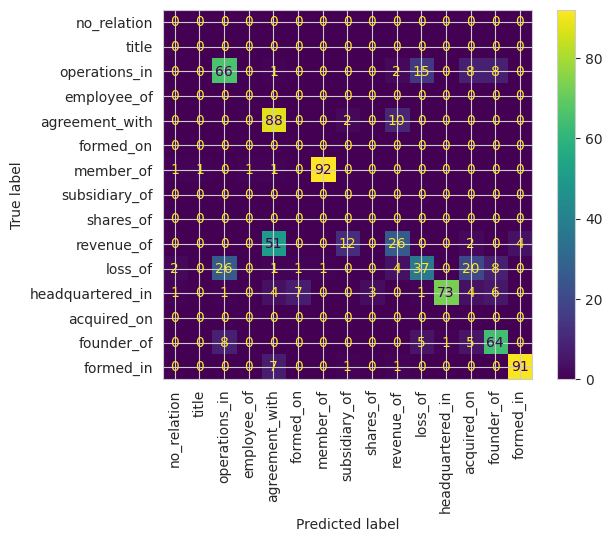

In [90]:
evaluate_performance(true_relations, predicted_relations, class_labels=class_labels)


Overall Performance:
Precision: 0.78
Recall: 0.70
F1 Score: 0.72

Class-wise Performance:
           Class  Precision   Recall  F1 Score
     no_relation   0.000000 0.000000  0.000000
           title   0.000000 0.000000  0.000000
   operations_in   0.653465 0.660000  0.656716
     employee_of   0.000000 0.000000  0.000000
  agreement_with   0.575163 0.880000  0.695652
       formed_on   0.000000 0.000000  0.000000
       member_of   0.989247 0.958333  0.973545
   subsidiary_of   0.000000 0.000000  0.000000
       shares_of   0.000000 0.000000  0.000000
      revenue_of   0.638298 0.315789  0.422535
         loss_of   0.637931 0.370000  0.468354
headquartered_in   0.986486 0.730000  0.839080
     acquired_on   0.000000 0.000000  0.000000
      founder_of   0.744186 0.771084  0.757396
       formed_in   1.000000 0.910000  0.952880

Classification Report:
                  precision    recall  f1-score   support

     no_relation       0.00      0.00      0.00         0
           title 

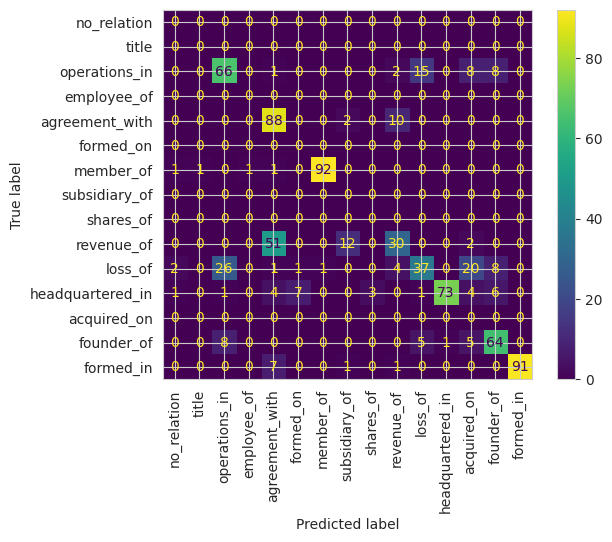

In [94]:
evaluate_performance(true_relations, fixed_predicted, class_labels=class_labels)


In [96]:
for pair in zip(predicted_relations, true_relations):
    if pair[0] != pair[1]:
        print(pair)

('member_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('member_of', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('formed_on', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('shares_of', 'no_relation')
('agreement_with', 'no_relation')
('formed_in', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_relation')
('agreement_with', 'no_rel